In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib as mpl

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure",figsize=(8, 4))

# Molecule 

In [3]:
from SCFInitialGuess.utilities.dataset import Molecule

angle_HCC = 121.3/180 *np.pi
distance_CC = 1.339
distance_CH = 1.087

mol = Molecule(
    species=["C", "C", "H", "H", "H", "H"],
    positions=[
        [ 0.00000,       0.00000,        0.00000],
        [ distance_CC  ,       0.00000,        0.00000],
        [ distance_CH * np.cos(angle_HCC), distance_CH * np.sin(angle_HCC), 0.00000],
        [ distance_CH * np.cos(2*np.pi - angle_HCC), distance_CH * np.sin(2*np.pi - angle_HCC), 0.00000],
        [ distance_CC + distance_CH * np.cos(np.pi - angle_HCC), distance_CH * np.sin(np.pi - angle_HCC), 0.00000],
        [ distance_CC + distance_CH * np.cos(- np.pi + angle_HCC), distance_CH * np.sin(- np.pi + angle_HCC), 0.00000]
    ]
)

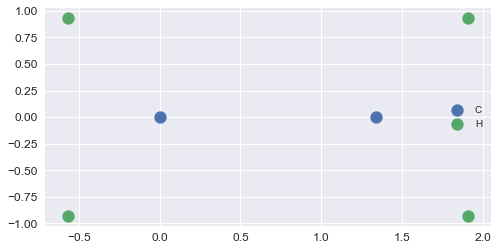

In [4]:
pos = np.array(mol.positions)
plt.scatter(pos[:2, 0], pos[:2, 1], label="C")
plt.scatter(pos[2:, 0], pos[2:, 1], label="H")
plt.legend()

# Utilities 

In [5]:
def activation(r, phi, theta, descriptor, values):
    
    radial_descriptor = descriptor.radial_descriptor
    angular_descriptor = descriptor.angular_descriptor
    
    return radial_descriptor.calculate_inverse_descriptor(
        r, 
        values[:radial_descriptor.number_of_descriptors]
    ) * angular_descriptor.calculate_inverse_descriptor(
        r,
        phi,
        theta,
        values[radial_descriptor.number_of_descriptors:]
    ) 

# Initialize Descriptors

## Utilities 

In [6]:
def plot_normal_model(model, t):
    for r_s, eta in zip(model[0], model[1]):
        plt.plot(t, np.exp(-1 * eta*(t - r_s)**2))
        
def plot_periodic_model(model, t):
    period = model[2]
    for r_s, eta in zip(model[0], model[1]):
        plt.plot(t,
            np.exp(-1 * eta * ((t % period) - r_s)**2) + \
            np.exp(-1 * eta * ((t % period) - period - r_s)**2)
        )

## Low Level 

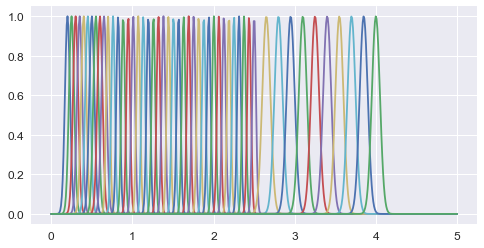

In [7]:
r_model_concentrated = (
    list(np.linspace(0.2, 0.7, 11))[:-1] + \
    list(np.linspace(0.7, 2.5, 30)) + \
    list(np.linspace(2.5, 4, 11))[1:],
    [500]*10 + \
    [1000]*30 + \
    [200]*10,
)

plot_normal_model(r_model_concentrated, np.linspace(0, 5, 500))

## High Level

In [29]:
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, SPHAngularDescriptor
from SCFInitialGuess.descriptors.cutoffs import \
    BehlerCutoff1
from SCFInitialGuess.descriptors.high_level import NonWeighted
    
    
descriptor = NonWeighted(
    Gaussians(*r_model_concentrated),
    SPHAngularDescriptor(15),
    BehlerCutoff1(5)
)

# C1 

In [30]:
values = descriptor.calculate_atom_descriptor(
    0,
    mol,
    descriptor.number_of_descriptors
)

## Radial 

## Angular 

In [33]:
np.arctan2(
    distance_CH * np.sin(angle_HCC), 
    distance_CC + distance_CH * np.cos(angle_HCC)
)

0.8758767105590083

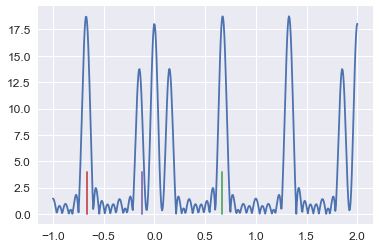

In [42]:
n_radial = descriptor.radial_descriptor.number_of_descriptors

phi = np.linspace(-np.pi, 2 * np.pi, 500)

plt.plot(
    phi / (np.pi ),
    descriptor.angular_descriptor.calculate_inverse_descriptor(
        None,
        phi,
        0.5 * np.pi,
        values[n_radial:]
    )
)
plt.plot([1/180*120]*2, [0, 4])
plt.plot([-1/180*120]*2, [0, 4])
plt.plot([0.8758767105590083 -1]*2, [0, 4])

## Surface 

In [37]:
R, Phi = np.meshgrid(
    np.linspace(0, 3, 500), 
    np.linspace(0, 2 * np.pi, 500)
)

theta = np.pi / 2



z = activation(
    R.flatten(),
    Phi.flatten(),
    theta,
    descriptor,
    values
)
th = 1e-10
#z[z<=th] = th

In [38]:
plt.rc("figure", figsize=(6,4))

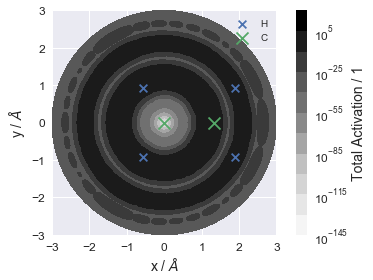

In [39]:
fig, ax = plt.subplots()

plt.contourf(
    (R * np.cos(Phi)),
    (R * np.sin(Phi)),
    z.reshape(*R.shape),
    locator=mpl.ticker.LogLocator()
)



plt.xlabel("x / $\AA$")
plt.ylabel("y / $\AA$")

plt.colorbar(label="Total Activation / 1")

plt.scatter(pos[2:, 0], pos[2:, 1], marker="x", s=60, label="H")
plt.scatter(pos[:2, 0], pos[:2, 1], marker="x", label="C")


plt.legend()

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#ax = plt.gca()
#ax.set_ylabel=("y / $\AA$")
#ax.set_xlabel=("x / $\AA$")

plt.tight_layout()


#plt.savefig("/home/jcartus/Repos/MastersThesis/AtomicBlocks/figures/XYPlaneActivation.pdf")
